In [13]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import os

#Loading data
processed_path = "../data/processed/"
input_file = os.path.join(processed_path, "combined_afdc_data.csv")

try:
    afdc_data = pd.read_csv(input_file)
    print(f"Successfully loaded combined AFDC dataset with {len(afdc_data)} records.")
except FileNotFoundError:
    print(f"ERROR: The file '{input_file}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

# Preparing data for time-series analysis
if 'Open Date' in afdc_data.columns:
    # Convert 'Open Date' to a datetime object, turning errors into NaT
    afdc_data['Open Date'] = pd.to_datetime(afdc_data['Open Date'], errors='coerce')
    afdc_data.dropna(subset=['Open Date'], inplace=True) # Remove rows where 'Open Date' could not be converted

    #aggregate by month
    # This counts how many new stations opened in each month
    monthly_openings = afdc_data.set_index('Open Date').resample('MS').size() # data will now be indexed by open date, resampled by month start (MS) and counted
    df_prophet = monthly_openings.reset_index() # reset index to turn the index back into a column

    # For prophet the columns need to be named ds for dates and y for the values
    df_prophet.columns = ['ds', 'y']

    print("Data prepared for Prophet:")
    print(df_prophet.tail()) #print last few rows to verify
    print(f"Total months of data: {len(df_prophet)}")
else:
    print("ERROR: 'Open Date' column not found in the loaded CSV file.")

Successfully loaded combined AFDC dataset with 16721 records.
Data prepared for Prophet:
            ds   y
472 2024-08-01  74
473 2024-09-01  40
474 2024-10-01  53
475 2024-11-01  52
476 2024-12-01  31
Total months of data: 477


In [ ]:
"""We split the data into training and test sets. Here, we use data up to the end of 2023 for training, and data from 2024 onwards for testing.
This allows us to evaluate the model's perfomance and accuracy on certain unseen data by the model."""
train_df = df_prophet[df_prophet['ds'] < '2024-01-01']
test_df = df_prophet[df_prophet['ds'] >= '2024-01-01']

print(f"\nTraining data points: {len(train_df)} months")
print(f"Test data points: {len(test_df)} months")

# Instantiate and fit the model
model = Prophet()
model.fit(train_df)
print("Prophet model has been trained.")


Training data points: 465 months
Test data points: 12 months


15:34:21 - cmdstanpy - INFO - Chain [1] start processing
15:34:22 - cmdstanpy - INFO - Chain [1] done processing


Prophet model has been trained.


Plotting the forecast


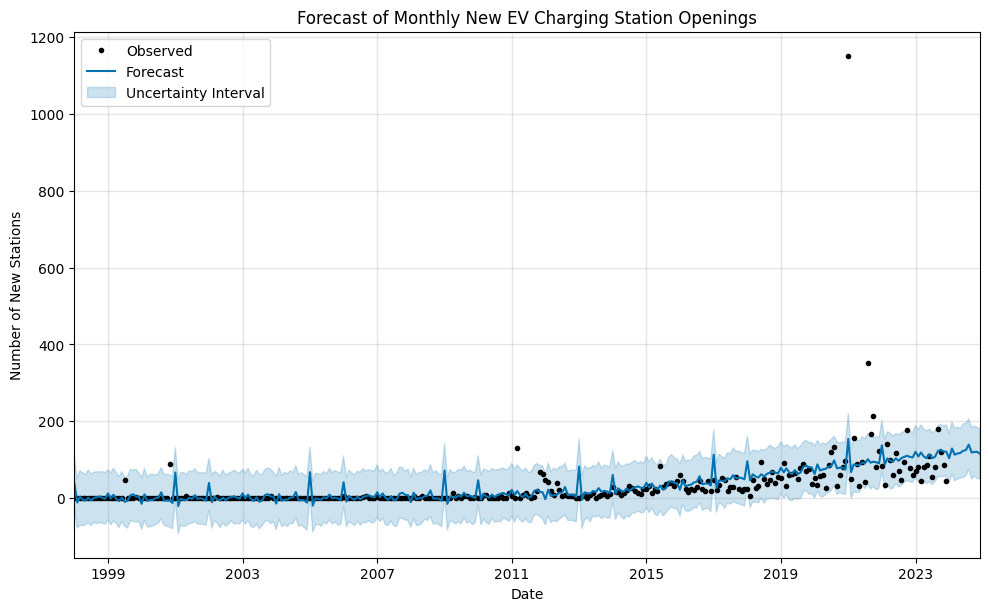

Evaluating result of model
Mean Absolute Error (MAE) on 2024 data: 79.42
This means the model's monthly forecasts are off by about 79.42 stations on average.


In [17]:
from sklearn.metrics import mean_absolute_error

#Create a future dataframe for predictions
future = model.make_future_dataframe(periods = 12, freq='MS')

#Create the forecast
forecast = model.predict(future)

#plot results
print("Plotting the forecast")
fig = model.plot(forecast)
ax = fig.gca() #gets current axis from the figure
plt.title("Forecast of Monthly New EV Charging Station Openings")
plt.xlabel("Date")
plt.ylabel("Number of New Stations")
plt.legend(["Observed", "Forecast", "Uncertainty Interval"])
start_date = pd.to_datetime('1998-01-01')
end_data = forecast['ds'].max()
ax.set_xlim([start_date, end_data])
plt.show()

#Evaluating model based off 2024 test set
predictions_on_test_period = forecast[forecast['ds'].isin(test_df['ds'])]
mae = mean_absolute_error(test_df['y'], predictions_on_test_period['yhat'])

print("Evaluating result of model")
print(f"Mean Absolute Error (MAE) on 2024 data: {mae:.2f}")
print(f"This means the model's monthly forecasts are off by about {mae:.2f} stations on average.")


In [11]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import os

#Loading AFDC data
processed_path = "../data/processed/"
input_file = os.path.join(processed_path, "combined_afdc_data.csv")

df = pd.read_csv(input_file)

# First, drop the duplicate station IDs, keeping the first time each station was recorded
unique_stations = df.drop_duplicates(subset=['ID'], keep='first')

# Now, count the non-null 'Open Date' values within this unique set
non_null_count = unique_stations['Open Date'].notna().sum()
total_unique_stations = len(unique_stations)
percentage_with_date = (non_null_count / total_unique_stations) * 100

print(f"Total unique stations found: {total_unique_stations}")
print(f"Unique stations with a valid 'Open Date': {non_null_count}")
print(f"Percentage of unique stations with an 'Open Date': {percentage_with_date:.2f}%")

unique_stations['Open Date'] = pd.to_datetime(unique_stations['Open Date'], errors='coerce')

# filter dates up to the end of 2024
stations_up_to_2024 = unique_stations[unique_stations['Open Date'] <= '2024-12-31']

# extract year
stations_up_to_2024['Year'] = stations_up_to_2024['Open Date'].dt.year

# count stations per year
stations_per_year = stations_up_to_2024.groupby('Year').size().reset_index(name='Station Count')

print(stations_per_year)

Total unique stations found: 4718
Unique stations with a valid 'Open Date': 2326
Percentage of unique stations with an 'Open Date': 49.30%
    Year  Station Count
0   2011              5
1   2012              5
2   2013              1
3   2014              2
4   2015              6
5   2016              5
6   2017              7
7   2018             19
8   2019             25
9   2020             18
10  2021            804
11  2022            393
12  2023            550
13  2024            486


C:\Users\taha_\AppData\Local\Temp\ipykernel_9860\1846248480.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_stations['Open Date'] = pd.to_datetime(unique_stations['Open Date'], errors='coerce')
C:\Users\taha_\AppData\Local\Temp\ipykernel_9860\1846248480.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_up_to_2024['Year'] = stations_up_to_2024['Open Date'].dt.year


In [3]:
import pandas as pd
import geopandas as gpd
import os

# --- 1. Load your two final datasets ---
processed_path = "../data/processed/"
input_file = os.path.join(processed_path, "afdc_unique_stations_with_features.geojson")

try:
    gdf_master = gpd.read_file(input_file)
    print(f"Successfully loaded master GeoDataFrame with {len(gdf_master)} records.")
except FileNotFoundError:
    print(f"ERROR: The file '{input_file}' was not found.")

gdf_master['Open Date'] = pd.to_datetime(gdf_master['Open Date'], errors='coerce')
gdf_master.dropna(subset=['Open Date'], inplace=True) # Remove rows where 'Open Date' could not be converted
print(f"After cleaning, {len(gdf_master)} records remain with valid 'Open Date'.")

gdf_master['open_year'] = gdf_master['Open Date'].dt.year

features = ['dist_to_major_road_m', 'poi_density_500m']
target = 'open_year' #based on the distance to a road and poi density, we want to predict the year a station opened

X = gdf_master[features]
y = gdf_master[target]


Successfully loaded master GeoDataFrame with 4718 records.
After cleaning, 2326 records remain with valid 'Open Date'.


In [6]:
#Training XGBoost
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error


# training and test split to test model
train_indices = gdf_master[gdf_master['open_year'] < 2024].index
test_indices = gdf_master[gdf_master['open_year'] >= 2024].index

#creating training and test sets
X_train, X_test = X.loc[train_indices], X.loc[test_indices]
y_train, y_test = y.loc[train_indices], y.loc[test_indices]

#checking size of the data
print(f"\nTraining data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

# Train the XGBoost Model 
#n_estimators is the number of trees we want to build
#random_state ensures reproducibility because XGBoost has some randomness in its algorithm
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
print("\nTraining XGBoost model")
xgb_reg.fit(X_train, y_train) #fit model to training data
print("Model training complete.")

# Make Predictions and Evaluate 
predictions = xgb_reg.predict(X_test)
predictions_rounded = predictions.round().astype(int) #round to nearest integer year
mae = mean_absolute_error(y_test, predictions_rounded) #check average error in years

print(f"\n--- XGBoost Model Evaluation ---")
print(f"Mean Absolute Error (MAE) on 2024 data: {mae:.4f} years")


Training data shape: (1840, 2)
Test data shape: (486, 2)

Training XGBoost model
Model training complete.

--- XGBoost Model Evaluation ---
Mean Absolute Error (MAE) on 2024 data: 2.2716 years


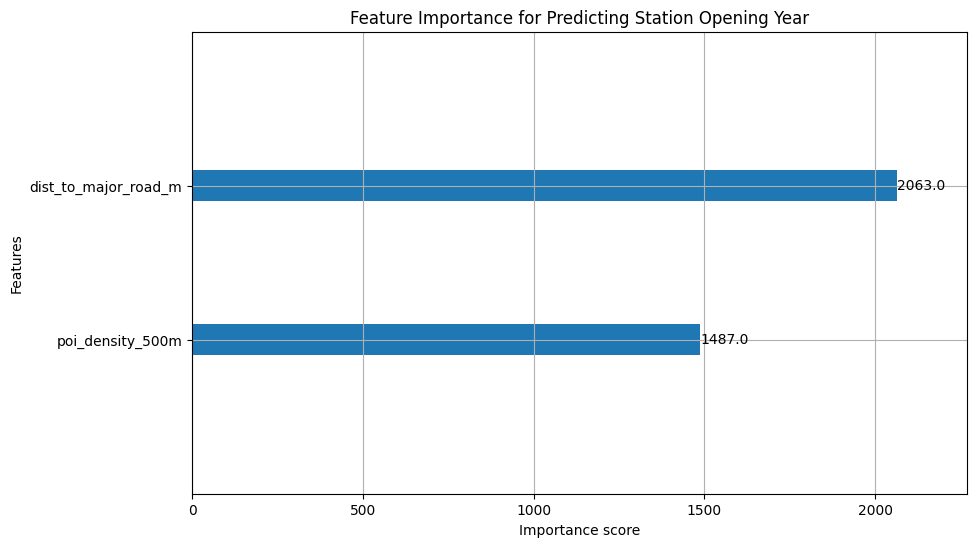

In [7]:
import matplotlib.pyplot as plt
import xgboost as xgb

# This visualizes which features the trained model ('xgb_reg') found most predictive.
fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(xgb_reg, ax=ax)
plt.title('Feature Importance for Predicting Station Opening Year')
plt.show()